In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from scipy.interpolate import interp1d

plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(20,8))
# set font size
plt.rc('font', size=15)
g = 9.81

Cells 6.0 Max thrust:  24.89778 N Max power 358.0 W Max current 15.41 A


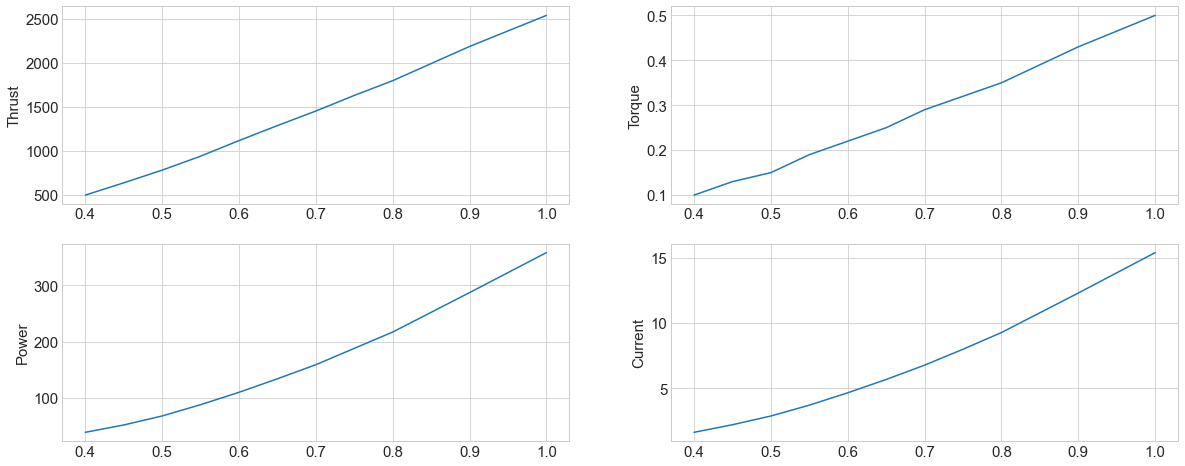

In [14]:
main_motor_data = np.genfromtxt('ref_data/MN5006_kv300_1758.csv', dtype=float, delimiter=',', names=True)
# interpolate thrust to torque and power
thrust_power_interp = interp1d(main_motor_data["Thrust"]*g/1000, main_motor_data["Power"], fill_value="extrapolate")
thrust_torque_interp = interp1d(main_motor_data["Thrust"]*g/1000, main_motor_data["Torque"], fill_value="extrapolate")
# throttle to thrust
throttle_thrust_interp = interp1d(main_motor_data["Thr"], main_motor_data["Thrust"]*g/1000, fill_value="extrapolate")
max_thrust = main_motor_data["Thrust"][-1]*g/1000
max_power =  main_motor_data["Power"][-1]
motor_standard_cells = np.floor(main_motor_data["Vol"][0]/3.6)
print("Cells", motor_standard_cells,  "Max thrust: ", max_thrust, "N", "Max power", max_power, "W", "Max current", main_motor_data["Cur"][-1], "A")

plt.subplot(221)
plt.plot(main_motor_data["Thr"], main_motor_data["Thrust"])
plt.ylabel("Thrust")
plt.subplot(222)
plt.plot(main_motor_data["Thr"], main_motor_data["Torque"])
plt.ylabel("Torque")
plt.subplot(223)
plt.plot(main_motor_data["Thr"], main_motor_data["Power"])
plt.ylabel("Power")
plt.subplot(224)
plt.plot(main_motor_data["Thr"], main_motor_data["Cur"])
plt.ylabel("Current")
# Read tail motor
tail_motor_data = np.genfromtxt('ref_data/F1204_kv5000_3016.csv', dtype=float, delimiter=',', names=True)
tail_thrust_power_interp = interp1d(tail_motor_data["Thrust"]*g/1000, tail_motor_data["Power"], fill_value="extrapolate")

No handles with labels found to put in legend.


Battery cells,Hover time (min),Thrust-to-weight ratio,Hover mass (kg),Hover power (W),Tail rotor power (W)
3,43.2673,1.96,0.4,36.9424,7.12297
4,49.8086,2.98667,0.45,42.7878,8.53191
5,54.7775,3.85467,0.5,48.6331,9.94085
6,58.6801,4.61455,0.55,54.4784,11.3498
8,64.2035,3.90462,0.65,66.3889,14.0672
12,66.9886,2.98588,0.85,95.443,18.6634


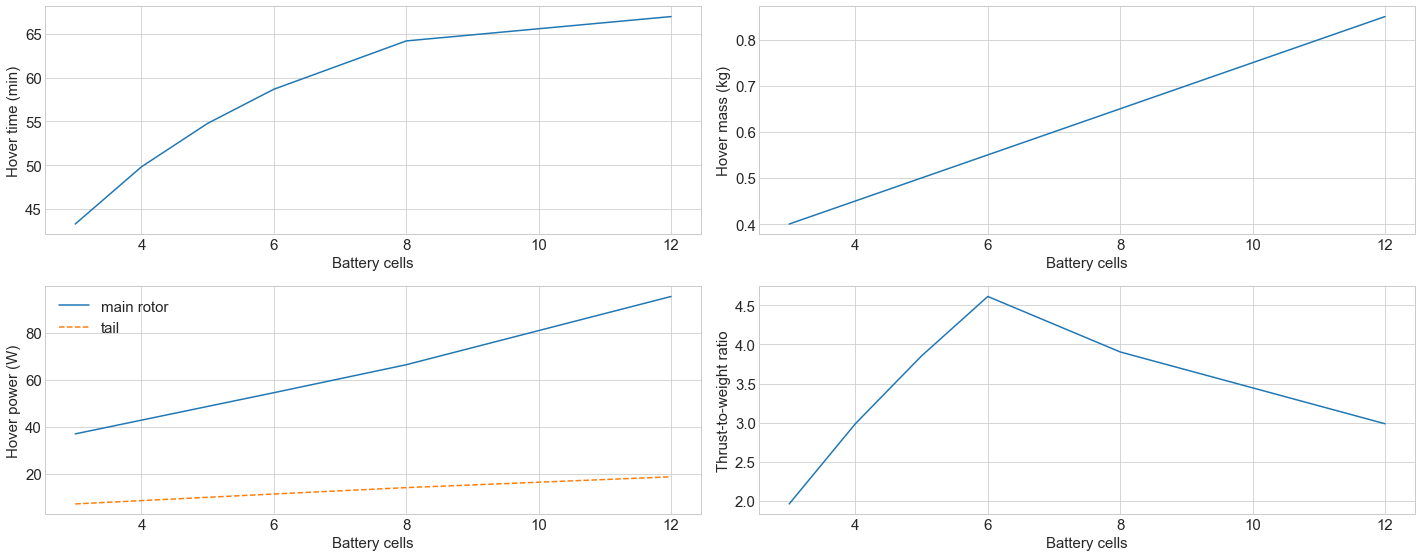

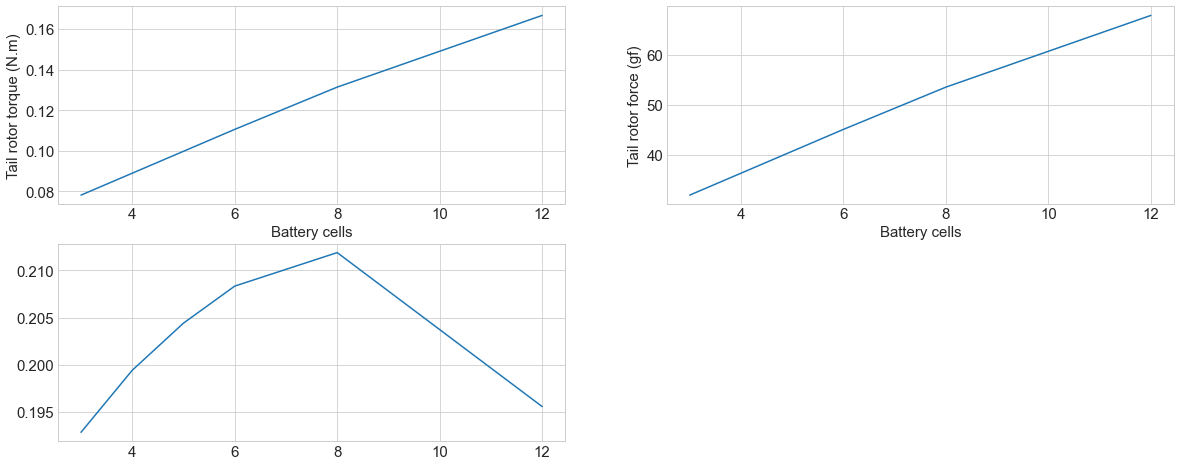

In [15]:
# Hover power consumption, 18650 or 21700 battery
net_mass = 0.25 # kg
# 18650, VTC6
battery_mass_per_cell = 0.05 # kg
battery_energy_per_cell = 3.7 * 3 * 3600 # mAh * V * 3600
# # 21700
# battery_mass_per_cell = 0.075 # kg
# battery_energy_per_cell = 3.7 * 5 * 3600 # mAh * V * 3600

# length from main rotor to tail rotor
l = 0.25 # m

#ratio of loss in Swashplateless design
loss_ratio = 0.8

#ratio of loss in tail control
tail_loss_ratio = 0.9

#Let's assume different battery configurations
battery_cells = [3, 4, 5, 6, 8, 12]

#Compute the hover power with different battery configurations
def hover_power(battery_cells):
    battery_mass = battery_mass_per_cell * battery_cells
    total_mass = net_mass + battery_mass
    # Now we need to compute the power to hover with thrust_interp
    main_rotor_power = thrust_power_interp(total_mass * g)
    torque = thrust_torque_interp(total_mass * g)
    tail_force = torque/l
    tail_power = tail_thrust_power_interp(tail_force) * tail_loss_ratio
    return main_rotor_power/loss_ratio, tail_power/tail_loss_ratio

#Compute the hover time with different battery configurations
def hover_time(battery_cells):
    hpower, tail_power = hover_power(battery_cells)
    battery_energy = battery_energy_per_cell * battery_cells 
    return battery_energy*loss_ratio/ hpower

def max_thrust_by_cells(cells):
    if cells > motor_standard_cells:
        cells = motor_standard_cells
    return throttle_thrust_interp(cells/motor_standard_cells)

# Draw battery cells vs hover time and mass and power
hover_times = [ hover_time(b)/60 for b in battery_cells]
hover_masses = [ net_mass + battery_mass_per_cell * b for b in battery_cells]
hover_powers = [ hover_power(b)[0] for b in battery_cells]
tail_powers = [ hover_power(b)[1] for b in battery_cells]
hover_torques = [ thrust_torque_interp(total_mass * g) for total_mass in hover_masses]
thrust_to_weight_ratio = [max_thrust_by_cells(cells)/g/mass for cells, mass in zip(battery_cells, hover_masses)]

plt.subplot(221)
plt.plot(battery_cells, hover_times)
plt.xlabel("Battery cells")
plt.ylabel("Hover time (min)")
plt.legend()
plt.subplot(222)
plt.plot(battery_cells, hover_masses)
plt.xlabel("Battery cells")
plt.ylabel("Hover mass (kg)")
plt.subplot(223)
plt.plot(battery_cells, hover_powers, label="main rotor")
plt.plot(battery_cells, tail_powers, linestyle="--", label="tail")
plt.legend()
plt.xlabel("Battery cells")
plt.ylabel("Hover power (W)")
plt.subplot(224)
#Plt thrust-to-weight ratio
plt.plot(battery_cells, thrust_to_weight_ratio)
plt.xlabel("Battery cells")
plt.ylabel("Thrust-to-weight ratio")
plt.tight_layout()

display(tabulate.tabulate(np.array([battery_cells, hover_times, thrust_to_weight_ratio, hover_masses, hover_powers, tail_powers,]).T, 
    headers=["Battery cells", "Hover time (min)", "Thrust-to-weight ratio", "Hover mass (kg)", "Hover power (W)", "Tail rotor power (W)"], 
    tablefmt='html'))
# Now we show the tail rotor power consumption using hover_torques
tail_forces = [torque/l for torque in hover_torques]
plt.figure()
#We show the torque and tail forces
plt.subplot(221)
plt.plot(battery_cells, hover_torques)
plt.xlabel("Battery cells")
plt.ylabel("Tail rotor torque (N.m)")
plt.subplot(222)

#Draw tail force in gf
plt.plot(battery_cells, [f*1000/9.81 for f in tail_forces])
plt.xlabel("Battery cells")
plt.ylabel("Tail rotor force (gf)")

#Tail power ratio
plt.subplot(223)
plt.plot(battery_cells, [f/p for f, p in zip(tail_powers, hover_powers)])


